In [51]:
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
from src.acquisition import *
from src.feature_engineering import *
from src.visualization import *

In [53]:
import pandas as pd 
import xgboost as xgb                                                           # gradient boosting algorithm
import optuna                                                                   # hyperparameter optimization
from catboost import CatBoostRegressor, Pool                                    # gradient boosting algorithm
import numpy as np


from sklearn.linear_model import LogisticRegression                             # linear fitting
from sklearn.ensemble import HistGradientBoostingClassifier, IsolationForest    # histogram boosting for NaN, IsolationForest?
from sklearn.cluster import KMeans                                              # K Means technique
from sklearn.neighbors import NearestNeighbors                                  # nearest neighbor 

from sklearn.model_selection import KFold, train_test_split, StratifiedGroupKFold
from sklearn.model_selection import cross_val_score, cross_val_predict  
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_columns', 15) 
pd.set_option('display.max_rows', 50)

seed = np.random.seed(578)

## 1. Data acquisition

## 1.2 $\textbf{3DSC}$ Database
$\textit{https://github.com/aimat-lab/3DSC}$ superconductor database 

In [54]:
train_path   = 'data/train.csv'
test_path    = 'data/test.csv'
crystal_path = 'data/Artificial_Crystals_Dataset.csv'
mineral_path = 'data/Mineral_Dataset_Supplementary_Info.csv'

In [55]:
train = acquisition_pipeline(path=train_path,drop_cols='id')
test = acquisition_pipeline(path=test_path,drop_cols='id')
crystal = acquisition_pipeline(path=crystal_path,drop_cols='Unnamed: 0',fill_NA_col='Crystal structure')
mineral = acquisition_pipeline(path=mineral_path,drop_cols='Unnamed: 0')

In [56]:
train.head()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
0,100.000,0.842,10.000,4.800,20.613,11.088,2.766,1.732,0.860,0.496,0.915,6.000
1,100.000,7.558,10.000,4.800,20.299,12.041,2.755,1.631,0.910,0.493,0.718,6.500
2,76.000,8.886,15.600,5.600,33.739,12.086,2.828,1.788,0.864,0.481,1.506,2.500
3,100.000,8.795,10.000,4.800,20.213,10.948,2.648,1.626,0.936,0.489,0.789,6.000
4,116.000,9.578,11.600,4.800,24.988,11.824,2.766,1.682,0.896,0.493,1.865,6.000


In [57]:
test.head()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average
0,884.000,121.420,35.360,5.280,82.561,9.370,2.298,1.907,1.200,0.462,1.795
1,90.000,9.932,18.000,5.600,39.568,12.086,2.868,1.652,0.864,0.476,1.412
2,116.000,7.768,11.600,4.800,23.232,11.024,2.644,1.794,0.960,0.500,0.788
3,100.000,9.108,10.000,4.800,20.299,12.086,2.828,1.662,0.792,0.496,1.205
4,55.000,4.030,11.000,4.000,22.978,11.281,2.455,1.750,0.893,0.476,0.935


## 2. Feature Engineering

In [58]:
ignore_features = ['id','Hardness','is_original']
features = [f for f in train.columns if f not in ignore_features]

In [59]:
fe_train = feature_engineering_pipeline(train,
        to_merge=mineral,                                        # merging data with mineral dataset                             
        ignore_outlier_features=ignore_features,                 # ignoring columns for outlier detection   
        outlier_col='Outlier',                                   # outlier column with True/FAlse
        std_features=features,std_method='robust',               # standardization method applied to features
        kmeans_features=features,k_clusters=5,                   # creating new columns with closest cluster + distance to it
        # new_column='Crystal structure',to_merge_NN=crystal
        )

fe_test = feature_engineering_pipeline(test,
        ignore_outlier_features=ignore_features,                 # ignoring columns for outlier detection   
        outlier_col='Outlier',                                   # outlier column with True/FAlse
        std_features=features,std_method='robust',               # standardization method applied to features
        kmeans_features=features,k_clusters=5,                   # creating new columns with closest cluster + distance to it
        # new_column='Crystal structure',to_merge=crystal
        )

[INFO.feature_engineering.merge_without_duplicates]: Found 23 duplicates
[ERROR.feature_engineering.feature_engineering_pipeline]:  list index out of range


In [60]:
fe_train.head()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
0,100.000,0.842,10.000,4.800,20.613,11.088,2.766,1.732,0.860,0.496,0.915,6.000
1,100.000,7.558,10.000,4.800,20.299,12.041,2.755,1.631,0.910,0.493,0.718,6.500
2,76.000,8.886,15.600,5.600,33.739,12.086,2.828,1.788,0.864,0.481,1.506,2.500
3,100.000,8.795,10.000,4.800,20.213,10.948,2.648,1.626,0.936,0.489,0.789,6.000
4,116.000,9.578,11.600,4.800,24.988,11.824,2.766,1.682,0.896,0.493,1.865,6.000


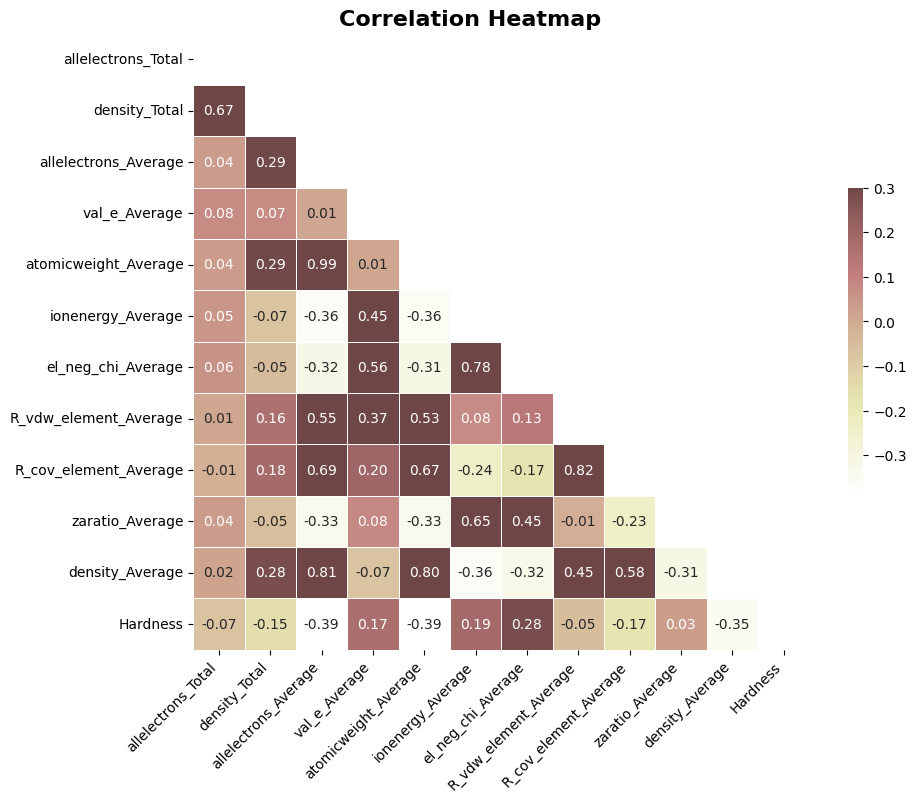

In [61]:
corr = fe_train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(10, 8))

heatmap = sns.heatmap(corr, mask=mask, cmap='pink_r', vmax=.3, center=0,
            annot=True, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

title = heatmap.set_title("Correlation Heatmap", weight='bold', size=16)
title.set_position([0.45, 1.1])
plt.show()

In [62]:
view_mutual_info_regression(fe_train,"Hardness")

+-----------------------+--------------------+
|        Feature        | Mutual Information |
+-----------------------+--------------------+
|  atomicweight_Average |       0.557        |
|    zaratio_Average    |        0.54        |
|   ionenergy_Average   |        0.5         |
| R_cov_element_Average |       0.475        |
|   el_neg_chi_Average  |       0.455        |
| R_vdw_element_Average |        0.45        |
|  allelectrons_Average |       0.435        |
|     density_Total     |       0.384        |
|     val_e_Average     |       0.336        |
|   allelectrons_Total  |       0.336        |
|    density_Average    |       0.224        |
+-----------------------+--------------------+


## 2.1 Train Test Split

In [63]:
y = fe_train['Hardness'].values
X = fe_train.drop(columns=['Hardness'])

In [64]:
X_train, X_val,y_train,y_val = train_test_split(X,y,test_size=0.2,shuffle=True,random_state=seed)

## 3. Model selection

In [65]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor
from xgboost import XGBRegressor
models = {
    'XGB': XGBRegressor(random_state=seed),
    'CAT': CatBoostRegressor(random_state=seed),
}


param_grids = {
    'XGB': {
        'max_depth': [3],
        'learning_rate': [0.06],
        'n_estimators': [270],
        'eval_metric': ['rmse'],
        'tree_method': ['exact'],
        'sampling_method':['uniform'],
        'subsample': [0.7],
        'colsample_bytree': [0.9],
        'reg_lambda': [0.2],
    },

    'CAT': {
        'verbose': [False],
        'random_seed': [42],
        'iterations': [3000],
        'loss_function': ['Quantile:alpha=0.5'],
        'depth': [7],
        'subsample':[0.7841394148733731],
        'learning_rate': [0.04442655333145627],
        'l2_leaf_reg': [3.523614847869309],
        'leaf_estimation_method': ['Exact'],
        'boost_from_average': [True],
    }
}


## 4. Training and Validation

In [66]:
best_models = {}
best_score = float('inf')

In [67]:
for model_name, model in models.items():
    param_grid = param_grids[model_name]

    grid_search = GridSearchCV(
            model,
            param_grid,
            cv=5,
            scoring='neg_median_absolute_error',
            verbose=False,
            return_train_score=True,
        )

    grid_search.fit(X_train, y_train)
    cv_results = grid_search.cv_results_

    best_models[model_name] = grid_search.best_estimator_

    # pretty-print model configurations
    print("=" * 170)
    for i, params in enumerate(cv_results['params']):
        score = abs(cv_results['mean_test_score'][i])
        print(f"[{model_name}]:\t{score}\t\t{params}\t")

[XGB]:	0.680527639389038		{'colsample_bytree': 0.9, 'eval_metric': 'rmse', 'learning_rate': 0.06, 'max_depth': 3, 'n_estimators': 270, 'reg_lambda': 0.2, 'sampling_method': 'uniform', 'subsample': 0.7, 'tree_method': 'exact'}	
[CAT]:	0.5275221848639176		{'boost_from_average': True, 'depth': 7, 'iterations': 3000, 'l2_leaf_reg': 3.523614847869309, 'leaf_estimation_method': 'Exact', 'learning_rate': 0.04442655333145627, 'loss_function': 'Quantile:alpha=0.5', 'random_seed': 42, 'subsample': 0.7841394148733731, 'verbose': False}	


In [68]:
ensemble_clf = VotingRegressor(
    estimators=[
        ('XGB',best_models['XGB']),
        ('CAT',best_models['CAT']),
    ],
    weights=[0.3, 0.7],
    verbose=True
)

## Forward Neural Network

In [69]:
from src.models.FNN32 import *

## Pre-fitting

In [92]:
from lightgbm import LGBMRegressor
model_pre = LGBMRegressor()
model_pre.fit(X, y)
X_new = X.copy()
X_new['Hardness'] = model_pre.predict(X)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2549
[LightGBM] [Info] Number of data points in the train set: 11006, number of used features: 11
[LightGBM] [Info] Start training from score 4.646097


In [93]:
model = create_model(X_new.columns)

history = model.fit(X_new.astype('float32'), y.astype('float32'),
                    epochs=100,
                    class_weight=model_pre.class_weight,
                    callbacks=callbacks_list,
                    validation_split=0.1)

Epoch 1/100
310/310 [==============================] - 2s 4ms/step - loss: 1.2293 - metric_fn: 4.6257 - val_loss: 0.8445 - val_metric_fn: 5.9216 - lr: 0.0130
Epoch 2/100
310/310 [==============================] - 1s 3ms/step - loss: 0.8257 - metric_fn: 3.2725 - val_loss: 0.5740 - val_metric_fn: 2.9183 - lr: 0.0130
Epoch 3/100
310/310 [==============================] - 1s 3ms/step - loss: 0.7408 - metric_fn: 3.1457 - val_loss: 0.5498 - val_metric_fn: 2.5081 - lr: 0.0130
Epoch 4/100
310/310 [==============================] - 1s 3ms/step - loss: 0.7326 - metric_fn: 3.1041 - val_loss: 0.5352 - val_metric_fn: 2.7939 - lr: 0.0130
Epoch 5/100
310/310 [==============================] - 1s 3ms/step - loss: 0.7402 - metric_fn: 3.1924 - val_loss: 0.6468 - val_metric_fn: 2.9677 - lr: 0.0130
Epoch 6/100
310/310 [==============================] - 1s 3ms/step - loss: 0.6029 - metric_fn: 3.2290 - val_loss: 0.5147 - val_metric_fn: 2.9682 - lr: 0.0130
Epoch 7/100
310/310 [==============================]

In [97]:
test_preds = model.predict(fe_test)

ValueError: Failed to find data adapter that can handle input: <class 'NoneType'>, <class 'NoneType'>

## 4.2 Validation

In [94]:
ensemble_clf.fit(X_train,y_train)

[Voting] ...................... (1 of 2) Processing XGB, total=   0.4s
[Voting] ...................... (2 of 2) Processing CAT, total=  18.3s


VotingRegressor(estimators=[('XGB',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=0.9, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric='rmse',
                                          feature_types=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rat...
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=3,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=270,
                                          n_jobs=None, num_parallel_tree=None,
                                          random_state=None, ...)),
                            ('CAT',
                             <catboost.core.CatBoostRegressor object at 0x000001CF70B36490>)],
                verbose=True, weights=[0.3, 0.7])

In [95]:
print("[MedAE]:\t\t", ensemble_clf.score(X_val,y_val))

[MedAE]:		 0.46553087218412714


## 5. Test Preparation

In [96]:
test_preds = ensemble_clf.predict(fe_test)

XGBoostError: [23:35:40] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:651: DMatrix/Booster has not been initialized or has already been disposed.

## Kaggle submission

In [ ]:
sample_df = pd.read_csv('data/sample_submission.csv')
sample_df['Hardness'] = test_preds  

sample_df.to_csv('data/sample_submission.csv', index=False)